Paper - Efficient representation of words in vector space

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Load the data
corpus = ["apple banana fruit",
          "banana apple fruit",
          "banana fruit apple",
          "dog cat animal",
          "cat animal dog",
          "cat dog animal"]

Note: Imagine each entry in the corpys as different documents with their data. The idea is and what we are trying to simulate is.. **word2vec to able to bring similar words close to each and dissimilar words far in the vector space**.

In [ ]:
# Preprocessing

corpus = [doc.split(" ") for doc in corpus] # Tokenization
corpus

[['apple', 'banana', 'fruit'],
 ['banana', 'apple', 'fruit'],
 ['banana', 'fruit', 'apple'],
 ['dog', 'cat', 'animal'],
 ['cat', 'animal', 'dog'],
 ['cat', 'dog', 'animal']]

In [ ]:
# Generate vocab - Flatten and generate vocab generally
tokens = [token for docs in corpus for token in docs]
vocab = list(set(tokens))
tokens, vocab

(['apple',
  'banana',
  'fruit',
  'banana',
  'apple',
  'fruit',
  'banana',
  'fruit',
  'apple',
  'dog',
  'cat',
  'animal',
  'cat',
  'animal',
  'dog',
  'cat',
  'dog',
  'animal'],
 ['banana', 'apple', 'cat', 'dog', 'animal', 'fruit'])

In [ ]:
# Flatten and generate vocab in a more compact way
flatten = lambda d: [token for sents in d for token in sents]
vocab = list(set(flatten(corpus)))
vocab

['banana', 'apple', 'cat', 'dog', 'animal', 'fruit']

In [ ]:
vocab.append("<UNK>")  # adding the unknown to handle unknown words

In [ ]:
vocab

['banana', 'apple', 'cat', 'dog', 'animal', 'fruit', '<UNK>']

In [ ]:
# Generate idx2word and word2idx
idx2word = {idx:word for idx, word in enumerate(vocab)}
word2idx = {v: k for k, v in idx2word.items()}

idx2word, word2idx

({0: 'banana',
  1: 'apple',
  2: 'cat',
  3: 'dog',
  4: 'animal',
  5: 'fruit',
  6: '<UNK>'},
 {'banana': 0,
  'apple': 1,
  'cat': 2,
  'dog': 3,
  'animal': 4,
  'fruit': 5,
  '<UNK>': 6})

Lowercase, removing URLs we can use ‘regex’ , remove non-word and non-whitespace characters, Tokenization, Stop word removal, Punctuations removal, HTML tags removal Stemming(porter stemming), Lematization, Morphology, POS Tagging, Named Entity Recognition and so on can be done. Here, we just do simple word tokenization.

In [ ]:
# Prepare Training Data - x and y pairs - pairs of center word, target context word

# Here we set window size 1, so each word have 2 pairs
# Ignore the first and last word as they dont have prefix and suffix words

def generate_skipgrams():
    skipgrams = []
    for doc in corpus:
        for i in range(1, len(doc)-1):  # we ignore the first and last as we dont have prefix and suffix words for them
            center_word = word2idx[doc[i]]
            target_context_words = [word2idx[doc[i-1]], word2idx[doc[i+1]]]  # 2 words as window size is 1
            for i in target_context_words:
                skipgrams.append([center_word, i])
    return skipgrams
skipgrams = generate_skipgrams()
skipgrams

[[0, 1],
 [0, 5],
 [1, 0],
 [1, 5],
 [5, 0],
 [5, 1],
 [2, 3],
 [2, 4],
 [4, 2],
 [4, 3],
 [3, 2],
 [3, 4]]

In [ ]:
# Lets see how the skip grams pairs were created
show_skipgrams = lambda s: [(idx2word[x], idx2word[y]) for x, y in s]
show_skipgrams(skipgrams)

[('banana', 'apple'),
 ('banana', 'fruit'),
 ('apple', 'banana'),
 ('apple', 'fruit'),
 ('fruit', 'banana'),
 ('fruit', 'apple'),
 ('cat', 'dog'),
 ('cat', 'animal'),
 ('animal', 'cat'),
 ('animal', 'dog'),
 ('dog', 'cat'),
 ('dog', 'animal')]

In [ ]:
corpus

[['apple', 'banana', 'fruit'],
 ['banana', 'apple', 'fruit'],
 ['banana', 'fruit', 'apple'],
 ['dog', 'cat', 'animal'],
 ['cat', 'animal', 'dog'],
 ['cat', 'dog', 'animal']]

In [ ]:
# Now generate x and y tensor as a whole as we feed x and y seperately to NN. Here, 0th index is x and 1st index is y.
data = np.array(skipgrams)
data.shape

(12, 2)

In [ ]:
x = data [:, 0]
y = data[:, 1]
x.shape, y.shape

((12,), (12,))

In [ ]:
x, y

(array([0, 0, 1, 1, 5, 5, 2, 2, 4, 4, 3, 3]),
 array([1, 5, 0, 5, 0, 1, 3, 4, 2, 3, 2, 4]))

In [ ]:
len(vocab), len(skipgrams)

(7, 12)

In [ ]:
# Now generate random batches and send them as tensors
vocab_size = len(vocab)
random_idxs = np.random.choice(range(len(skipgrams)), size=2, replace=False)  # Batch size 2
random_idxs

array([9, 0])

In [ ]:
# now return the batch of x's and y's
torch.LongTensor(x[random_idxs]), torch.LongTensor(y[random_idxs])

(tensor([4, 0]), tensor([3, 1]))

In [ ]:
# Now make this whole skipgrams to batch generation as a single function.
def generate_batch(corpus, window_size=1, batch_size=2):
    skipgrams = []
    for doc in corpus:
        for i in range(1, len(doc)-1):
            center_word = word2idx[doc[i]]
            target_contex_words = [word2idx[doc[i - 1]], word2idx[doc[i + 1]]]
            for ctx in target_contex_words:
                skipgrams.append([center_word, ctx]) # skipgram
    random_idxs = np.random.choice(range(len(skipgrams)), batch_size, replace=False)
    x, y = [], []
    for idx in random_idxs:
        x.append([skipgrams[idx][0]])
        y.append([skipgrams[idx][1]])
    x = torch.LongTensor(np.array(x))
    y = torch.LongTensor(np.array(y))
    return x, y

In [ ]:
generate_batch(corpus)

(tensor([[5],
         [5]]),
 tensor([[0],
         [1]]))

In [ ]:
x, y = generate_batch(corpus)
x.shape, y.shape

(torch.Size([2, 1]), torch.Size([2, 1]))

In [ ]:
# Embedding Layer - generate random embedding for every index of the vocab
# First int represent number of vocabs that can exist starting from 0 to n-1, and second int represents resulting embeding vector dim
# Eg: nn.Embedding(2, 3) - the embedding layer(sometimes called as look up table) can return random embeddings for 0, 1 index of size 3.
# If the input we send to embedding layer has 0 in it, then it get 0th indexed vector(random)
# If the input we send to embedding layer has 1 in it, then it get 1st indexed vector(random)
# If the input we send to embedding layer has 2 value in it, then it retuns index out of bounds error as we only have embeddings upto 1 in embedding lookup table and not for 2.
# Think of it as dictionary where it gets vectors(values) based on given input values(keys)
embedding = nn.Embedding(2, 3)
input = torch.LongTensor([0])
input.shape

torch.Size([1])

In [ ]:
embedding(input)

tensor([[ 0.1902, -0.2206, -0.9987]], grad_fn=<EmbeddingBackward0>)

In [ ]:
input = torch.LongTensor([1])
embedding(input)

tensor([[-0.8810, -0.2581,  0.2744]], grad_fn=<EmbeddingBackward0>)

In [ ]:
# input = torch.LongTensor([2])
# embedding(input)

The Skip-Gram model is basically a shallow neural network with an input layer, embedding layer and output layer. Note that the model doesnt have any non-linear activations in it. The model’s aim is to produce an output probability distribution vector given a target word input. This probability distribution vector (which sums to 1) reflects the probability for each word to appear in the target word’s context window. As one might expect, we are interested in locating the probability to be high for words who share the same context and low for words who don’t.The intriguing part about this is that we just require the model’s weights once it has been trained.

How the model accounts for the (target word, context word) pairings that were previously described is, that the target words function as the input (X_train), while the context words function as the output (y_train).

**The Loss Function:**

To obtain useful vector embeddings, we have to optimize the weights in our model, which are initially set to be entirely random. The optimization process is carried out in order to minimize the loss function:

\begin{equation}
J = -\sum_{t=1}^T \sum_{-m \le j \le m} log(P(w_{t+j} | w_t))
\end{equation}

where T = text length, m = window size, $P(w_{t+j}|w_t)$ is the probability to get context word given target word.

**How to read this equation?**

It is merely a nested loop, which requires us to iterate over all (target word, context word) pairs and sum up the probabilities. The minus sign is just for convenience — in ML we prefer minimizing the loss function’s value instead of maximizing it. It is nothing but negative log likelihood.

**How are these probabilities calculated?**

In order to calculate the probability distribution, we use the Softmax function which takes into account the dot product of the target embedding vector and embedding vectors of each and every word in our vocabulary:

\begin{equation}
u^T v = u . v = \sum_{i=1}^n u_i v_i
\end{equation}

\begin{equation}
P(context\ word | target\ word)  \frac{exp(u^{T}_{target} v_{context})}{\sum_{w=1}^{words} exp(u^T_{target} v_{w})}
\end{equation}

The numerator is the normalizing factor which takes up all the vocabs in the vocab. Sometimes if the vocab is too large, this would be intractable.

Some notes and clarifications before we move on to the implementation:

1. Regarding the model purpose — As opposed to a traditional neural network that is used for classification, over here our objective is to train the network in order to extract the weights. In summary, there is no need to use it in the traditional manner of input -> model -> output.

2. Regarding the model’s weights — As opposed to a typical neural network, where the weights are used to handle any input, the skip-gram model assigns unique weights to each and every word. This means that the model’s weights cannot be generalized to handle new words or inputs in the same way. Instead, the weights serve as specific embeddings for each word.

3. Using one hot encoding is not required — According to various blog entries, every word is converted into a one-hot encoding vector which we pass to the model (like ‘rick’ = [0,0,0,…1,…0]). Despite being the standard, using a sparse vector makes little sense. Instead, we can just pass the word’s index which is less memory consuming.

In [ ]:
# Skip Gram Model
class SkipGram(nn.Module):
    def __init__(self, vocab_size, embed_dim, *args, **kwargs) -> None:
        super(SkipGram, self).__init__(*args, **kwargs)
        # Input embedding (for center word)
        self.embedding_inp_target = nn.Embedding(vocab_size, embed_dim)
        # Output embedding (for context word)
        self.embedding_out_ctx = nn.Embedding(vocab_size, embed_dim)

    def forward(self, x_center, y_ctx, all_vocabs):
        # print(f"X: {x_center.shape}, Y: {y_ctx.shape}")                                           # (bs, 1), (bs, 1)
        target_ctr_embed = self.embedding_inp_target(x_center)                                    # (bs, 1) (voc_size, embed_dim) -> vocindexlookup-> (bs, 1, embed_dim)
        ctx_embed = self.embedding_out_ctx(y_ctx)                                                 # (bs, 1) (voc_size, embed_dim) -> vocindexlookup-> (bs, 1, embed_dim)
        all_vocabs_embed = self.embedding_out_ctx(all_vocabs)                                  # (bs, voc_size) (voc_size, embed_dim) -> (bs, voc_size, embed_dim)
        # print(f"Target Embedding: {target_ctr_embed.shape}\n Context Embedding: {ctx_embed.shape}\n All vocabs embedding: {all_vocabs_embed.shape}")
        # Softmax
        numerator = torch.exp(ctx_embed.bmm(target_ctr_embed.transpose(1, 2)).squeeze(dim=2))           # (bs, 1, embed_dim), (bs, embed_dim, 1) -> (bs, 1, 1) -> squeeze -> (bs, 1) -> exp -> (bs, 1)
        denominator = torch.exp(all_vocabs_embed.bmm(target_ctr_embed.transpose(1, 2)).squeeze(dim=2))  # (bs, voc_size, embed_dim), (bs, embed_dim, 1) -> (bs, voc_size, 1) -> squeeze -> (bs, voc_size) -> exp -> (bs, voc_size)
        denominator_sum = torch.sum(denominator, dim=1)                                                 # (bs, voc_size) -> (bs,)
        prob_scores = numerator / denominator_sum                                                       # (bs, 1) , (bs,) -> (bs, bs) -> (broadcasting rule)
        # print(f"numerator: {numerator.shape}, denominator: {denominator.shape}, denominator_sum: {denominator_sum.shape} prob_scores: {prob_scores.shape}")
        # NLL
        log_probs = torch.log(prob_scores + 1e-6)                                                 # (bs, bs)
        loss = -torch.mean(log_probs)                                                             # scalar
        return loss


**Shapes info**
for bs=2, embed_dim=3
- X: torch.Size([2, 1]), Y: torch.Size([2, 1])
- Target Embedding: torch.Size([2, 1, 3])
- Context Embedding: torch.Size([2, 1, 3])
- All vocabs embedding: torch.Size([2, 7, 3])
- numerator: torch.Size([2, 1]), denominator: torch.Size([2, 7]), denominator_sum: torch.Size([2]) prob_scores: torch.Size([2, 2])

### 🧠 Why Two Embeddings in Skip-Gram?

In Skip-Gram, we want to predict **context words** from a given **center word**.

To do this, we use **two separate embedding matrices**:

- **Input Embedding Matrix**: used when the word is a **center** word.
- **Output Embedding Matrix**: used when the word is a **context** word.

We need both because the same word behaves differently when used to predict others (center role) versus when it is being predicted (context role).

Each matrix captures a different "view" of the word:
- Input embeddings learn what kind of words a center word points to.
- Output embeddings learn how likely a word is to appear around certain centers.

🧾 **Inference**:  
At inference time, we usually:
- Use just the **input embeddings** as the final word vectors, or
- **Average** input and output embeddings for a more general representation.


**WHy are we not taking the true context as input in the loss function?**

What are we doing in the code is implementing a **manual negative log-likelihood loss** for the Skip-gram model:

```python
loss = -torch.mean(torch.log(numerator / (denominator_sum)))
```

### Let's unpack:
- **`numerator`** is `exp(sim(center, true context))`
- **`denominator_sum`** is the sum over all vocab words:  
  `∑_w exp(sim(center, w))`

So this is equivalent to:

\begin{equation}
\text{loss} = -\frac{1}{N} \sum_{i=1}^N \log \left( \frac{\exp(\text{sim}(c_i, o_i))}{\sum_w \exp(\text{sim}(c_i, w))} \right)
\end{equation}

This i* comparing the center word with the **true context word** — it just doesn't look like a comparison at first glance, because it's using the **index-based matrix math**, not a loop.

---

So yes — we ARE checking the true context words. We do this with:
```python
outside_embedding = self.embedding_outside(outside)
```
This grabs the correct **true context word embeddings** for each center word in the batch. So the `numerator` is **only for the correct context word**, and the `denominator_sum` includes **all possible words** (softmax denominator).

Even though we don't explicitly loop over the "true" labels or use `.gather()`:
- The **numerator** is the similarity with the true context word
- The **denominator** is the similarity with all words in the vocab

So, this loss function is doing the same thing as CrossEntropy or nn.LogSoftmax, but manually.We are comparing center with true context — no .gather() needed.



In [ ]:
vocab, word2idx, vocab_size

(['banana', 'apple', 'cat', 'dog', 'animal', 'fruit', '<UNK>'],
 {'banana': 0,
  'apple': 1,
  'cat': 2,
  'dog': 3,
  'animal': 4,
  'fruit': 5,
  '<UNK>': 6},
 7)

In [ ]:
# prepare all_vocabs
def prepare_all_vocabs(vocab_seq, word2idx, batch_size=2):
    vocab_size = len(vocab)
    idxs = list(map(lambda w: word2idx[w] if word2idx.get(w) is not None else word2idx["<UNK>"], vocab_seq))
    all_vocabs = torch.LongTensor(idxs).expand(size=(batch_size, vocab_size))
    return all_vocabs

all_vocabs = prepare_all_vocabs(vocab, word2idx)
all_vocabs, all_vocabs.shape

(tensor([[0, 1, 2, 3, 4, 5, 6],
         [0, 1, 2, 3, 4, 5, 6]]),
 torch.Size([2, 7]))

In [ ]:
prepare_all_vocabs(vocab, word2idx, 4)

tensor([[0, 1, 2, 3, 4, 5, 6],
        [0, 1, 2, 3, 4, 5, 6],
        [0, 1, 2, 3, 4, 5, 6],
        [0, 1, 2, 3, 4, 5, 6]])

In [ ]:
x, y, x.shape, y.shape

(tensor([[0],
         [4]]),
 tensor([[1],
         [2]]),
 torch.Size([2, 1]),
 torch.Size([2, 1]))

In [ ]:
vocab_size = len(vocab)
model = SkipGram(vocab_size, embed_dim=3)
model(x, y, all_vocabs)

tensor(1.8421, grad_fn=<NegBackward0>)

In [ ]:
model

SkipGram(
  (embedding_inp_target): Embedding(7, 3)
  (embedding_out_ctx): Embedding(7, 3)
)

In [ ]:
model.embedding_inp_target

Embedding(7, 3)

In [ ]:
model.embedding_inp_target(torch.LongTensor([2]))  # 3 dims here for our word idx

tensor([[0.4555, 1.6644, 2.0217]], grad_fn=<EmbeddingBackward0>)

In [ ]:
# Training Loop
vocab_size = len(vocab)
model = SkipGram(vocab_size, embed_dim=2)
epochs = 5000
lr = 1e-2
optimizer = torch.optim.Adam(lr=lr, params=model.parameters())

# model.train()
for i in range(epochs):
    x, y = generate_batch(corpus, batch_size=2)
    optimizer.zero_grad()
    loss = model(x, y, all_vocabs)
    if (i + 1) % 1000 == 0:
        print(f"Epoch:{i+1:6.0f} | Loss: {loss:2.6f}")
    loss.backward()
    optimizer.step()

Epoch:  1000 | Loss: 0.774174
Epoch:  2000 | Loss: 0.999821
Epoch:  3000 | Loss: 0.870135
Epoch:  4000 | Loss: 0.645119
Epoch:  5000 | Loss: 0.866453


### Plot the embeddings

Is fruit really near to banana? Is fruit really far from cat?

In [ ]:
idx = word2idx["banana"]
word = torch.LongTensor([idx])

In [ ]:
embed_ctr = model.embedding_inp_target(word)
embed_ctr, embed_ctr.shape

(tensor([[-0.0415, -0.1351]], grad_fn=<EmbeddingBackward0>),
 torch.Size([1, 2]))

In [ ]:
embed_ctx = model.embedding_out_ctx(word)
embed_ctx, embed_ctx.shape

(tensor([[ 0.6703, -4.0438]], grad_fn=<EmbeddingBackward0>),
 torch.Size([1, 2]))

In [ ]:
embed = (embed_ctx + embed_ctr) / 2
embed, embed.shape

(tensor([[ 0.3144, -2.0894]], grad_fn=<DivBackward0>), torch.Size([1, 2]))

In [ ]:
def get_embed(word):
    try:
        idx = word2idx[word]
    except:
        idx = word2idx["<UNK>"]

    word = torch.LongTensor([idx])

    embed_ctr = model.embedding_inp_target(word)
    embed_ctx = model.embedding_out_ctx(word)
    embed = (embed_ctx + embed_ctr) / 2
    # print(embed.shape, embed)  # torch.Size([1, 2]) tensor([[-1.6618,  1.1101]], grad_fn=<DivBackward0>)
    return embed[0][0].item(), embed[0][1].item()

In [ ]:
get_embed("banana")

(0.3143775165081024, -2.0894336700439453)

In [ ]:
get_embed("apple")

(0.7766761183738708, -7.404226303100586)

In [ ]:
get_embed("cat")

(-1.0785130262374878, 1.1910436153411865)

In [ ]:
get_embed("dog")

(-1.2210053205490112, 1.460604190826416)

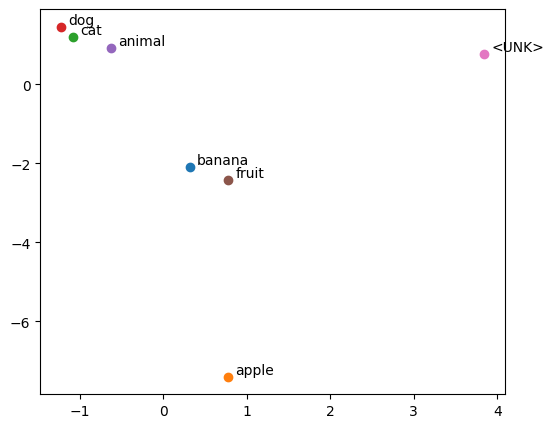

In [ ]:
# plot
plt.figure(figsize=(6, 5))
for i, word in enumerate(vocab):
    x, y = get_embed(word)
    plt.scatter(x, y)  # we can plot easily as we have set the embedding dim to just 2. for more dims, we can use pca or tsne
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords="offset points")
plt.show()

### Evaluation

There are various approaches to evaluate the word embeddings quality. Listed below 4 of them:

(1) Visualizing — useful for determining if the embedding makes sense. Bear in mind that it could be overwhelming to visualize every word at once, so you might want to choose a group of words that really caught your attention.

(2) Cosine similarity function — This function compares two word embeddings to see how similar they are. If the cosine similarity equals 1 it means the vectors are identical, where value -1 means that the vectors are exactly opposite, and value 0 indicates they are orthogonal.

\begin{equation}
cosθ = \frac{A\ . B}{||A||\ ||B||} = \frac{ \sum_{i=1}^{n} A_iB_i } { \sqrt{\sum_{i=1}^n A_i^2} . \sqrt{\sum_{i=1}^n B_i^2} }
\end{equation}

(3) Word Similarity Task — An evaluation task that includes word pairs with human-annotated similarity scores. Here is one dataset — WordSim-353

(4) Analogies Tasks — this one involves completing word analogies of the form “vec(Pickle Rick) — vec(Rick) + vec(Morty) =>>> vec(pickle Morty)”.

In [146]:
## Cosine Similarity

a = get_embed("banana")
b = get_embed("apple")
c = get_embed("dog")

In [144]:
np.array(a) @ np.array(b)

np.float64(1.2530202318083132)

In [147]:
np.array(a) @ np.array(c)

np.float64(-0.7104070928859816)

In [148]:
def cosine_similarity(a, b):
    dot_product = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    similarity = dot_product / (norm_a * norm_b)
    return similarity

print(cosine_similarity(np.array(a), np.array(c)))
print(cosine_similarity(np.array(a), np.array(b)))

-0.34130933100511335
0.9680830300290912


### Self Practice

In [128]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# Prepare data
corpus = ["apple banana fruit", "banana apple fruit", "banana fruit apple",
          "dog cat animal", "cat animal dog", "cat dog animal"]
preprocess = lambda d: [sent.split(" ") for sent in d]
corpus = preprocess(corpus)

# Flatten and Generate vocab
flatten = lambda docs: [sent for d in docs for sent in d]
all_vocab = list(set(flatten(corpus)))
all_vocab.append("<UNK>")

# Generate word2idx and idx2word dictionaries
voc_size = len(all_vocab)
idx2word = {idx:word for idx, word in enumerate(all_vocab)}
word2idx = {v: k for k, v in idx2word.items()}

# Prepare inputs to the model

# Generate skipgram pairs (x, y) -> (target, context) pairs
def generate_input_pairs(corpus, batch_size, window_size=1):
    word_pairs = []
    for doc in corpus:
        for i in range(1, len(doc)-1):
            center_word = word2idx[doc[i]]
            ctx_words = [word2idx[doc[i-1]], word2idx[doc[i+1]]]
            for ctx in ctx_words:
                word_pair = [center_word, ctx]
                word_pairs.append(word_pair)

    batch_idxs = np.random.choice(len(word_pairs), size=batch_size, replace=False)
    x, y = [], []
    for idx in batch_idxs:
        x.append([word_pairs[idx][0]])  # 2d
        y.append([word_pairs[idx][1]])  # 2d
    return torch.LongTensor(x), torch.LongTensor(y)

# Generate expanded idxs for all vocabs for softmax denominator purpose
def generate_all_vocabs(vocab_seq, batch_size):
    all_vocabs = list(map(lambda word: word2idx.get(word) if word in word2idx else word2idx["<UNK>"], vocab_seq))
    all_vocabs_expanded = torch.LongTensor(all_vocabs).expand(batch_size, -1)
    return all_vocabs_expanded

# Model
class SkipGram(nn.Module):
    def __init__(self, voc_size, embed_size=2):
        super(SkipGram, self).__init__()
        self.embed_ctr_in = nn.Embedding(num_embeddings=voc_size, embedding_dim=embed_size)
        self.embed_ctx_out = nn.Embedding(num_embeddings=voc_size, embedding_dim=embed_size)

    def forward(self, x, y, all_vocabs_expanded):
        # print(x.shape, y.shape)                                                               # (bs, 1), (bs, 1)
        x_ctr = self.embed_ctr_in(x)                                                            # bs, 1, emb
        y_ctx = self.embed_ctx_out(y)                                                           # bs, 1, emb
        all_vocabs_expanded = self.embed_ctx_out(all_vocabs_expanded)                           # bs, 7, emb
        # softmax
        numerator = torch.exp(y_ctx.bmm(x_ctr.transpose(1, 2)).squeeze(dim=2))                  # bs, 1, 1 -> bs, 1
        denominator = torch.exp(all_vocabs_expanded.bmm(x_ctr.transpose(1, 2)).squeeze(dim=2))  # bs, 7, 1 -> bs, 7
        denominator_sum = denominator.sum(dim=1)                                                # bs
        probs = numerator / denominator_sum                                                     # (bs, 1) (bs) -> (bs, bs)
        # loss
        log_probs = torch.log(probs + 1e-6)                                                     # (bs, bs)
        loss = -torch.mean(log_probs)                                                           # scalar
        return loss

# Training
batch_size = 2
lr = 1e-3
voc_size = len(all_vocab)
model = SkipGram(voc_size=voc_size, embed_size=2)
epochs = 10000
optimizer = optim.Adam(lr=lr, params=model.parameters())

for i in range(epochs):
    x, y = generate_input_pairs(corpus, batch_size)
    all_vocabs = generate_all_vocabs(all_vocab, batch_size)
    optimizer.zero_grad()
    loss = model(x, y, all_vocabs)
    if (i+1) % 1000 == 0:
        print(f"Epoch: {i+1:6.0f} | Loss: {loss:2.6f}")
    loss.backward()
    optimizer.step()


Epoch:   1000 | Loss: 1.588510
Epoch:   2000 | Loss: 1.214383
Epoch:   3000 | Loss: 1.438176
Epoch:   4000 | Loss: 1.545083
Epoch:   5000 | Loss: 1.047998
Epoch:   6000 | Loss: 1.125410
Epoch:   7000 | Loss: 0.828121
Epoch:   8000 | Loss: 0.782330
Epoch:   9000 | Loss: 1.642500
Epoch:  10000 | Loss: 0.903865


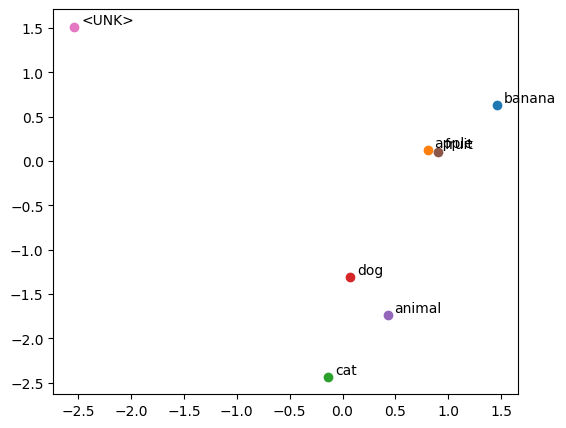

In [141]:
# Plotting the embedding
def get_embed(word):
    try:
        idx = torch.LongTensor([word2idx[word]])
    except:
        idx = torch.LongTensor([word2idx["<UNK>"]])
    embed_c = model.embed_ctr_in(idx)
    embed_o = model.embed_ctx_out(idx)
    embed = (embed_c + embed_o) / 2
    return embed[0][0].item(), embed[0][1].item()

import matplotlib.pyplot as plt
plt.figure(figsize=(6, 5))
for word in all_vocab:
    x, y = get_embed(word)
    plt.scatter(x, y)
    plt.annotate(text=word, xy=(x, y), xytext=(5, 2), textcoords="offset points")
plt.show()


In [151]:
def cosine_similarity(a, b):
    dot = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    similarity = dot / (norm_a * norm_b)
    return similarity

a = np.array(get_embed("apple"))
b = np.array(get_embed("fruit"))
c = np.array(get_embed("unknown"))


In [150]:
cosine_similarity(a, b)

np.float64(0.9994680157863237)

In [152]:
cosine_similarity(a, c)

np.float64(-0.7711975056146004)

In [154]:
cosine_similarity(b, a)

np.float64(0.9994680157863237)

In [153]:
cosine_similarity(b, b)

np.float64(1.0000000000000002)

### Implementation using Libraries on Pickle Rick Transcript

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Epoch num: 1, total_batches: 1003 loss value: 11.913
Epoch num: 2, total_batches: 1003 loss value: 11.774
Epoch num: 3, total_batches: 1003 loss value: 13.671
Epoch num: 4, total_batches: 1003 loss value: 13.356
Epoch num: 5, total_batches: 1003 loss value: 11.602
Epoch num: 6, total_batches: 1003 loss value: 10.738
Epoch num: 7, total_batches: 1003 loss value: 9.690
Epoch num: 8, total_batches: 1003 loss value: 9.094
Epoch num: 9, total_batches: 1003 loss value: 8.370
Epoch num: 10, total_batches: 1003 loss value: 8.159


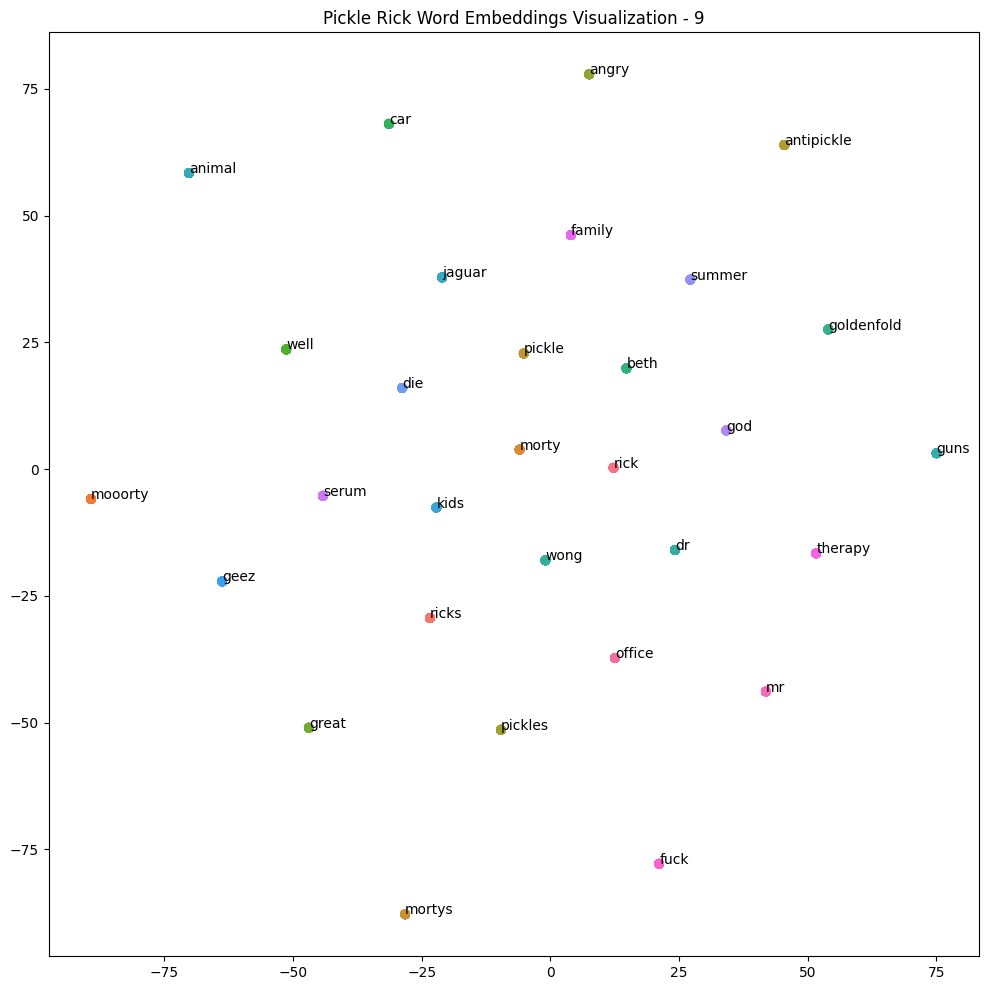

Epoch num: 11, total_batches: 1003 loss value: 7.832
Epoch num: 12, total_batches: 1003 loss value: 7.448
Epoch num: 13, total_batches: 1003 loss value: 7.177
Epoch num: 14, total_batches: 1003 loss value: 7.064
Epoch num: 15, total_batches: 1003 loss value: 6.975
Epoch num: 16, total_batches: 1003 loss value: 6.749
Epoch num: 17, total_batches: 1003 loss value: 6.667
Epoch num: 18, total_batches: 1003 loss value: 6.626
Epoch num: 19, total_batches: 1003 loss value: 6.579
Epoch num: 20, total_batches: 1003 loss value: 6.489


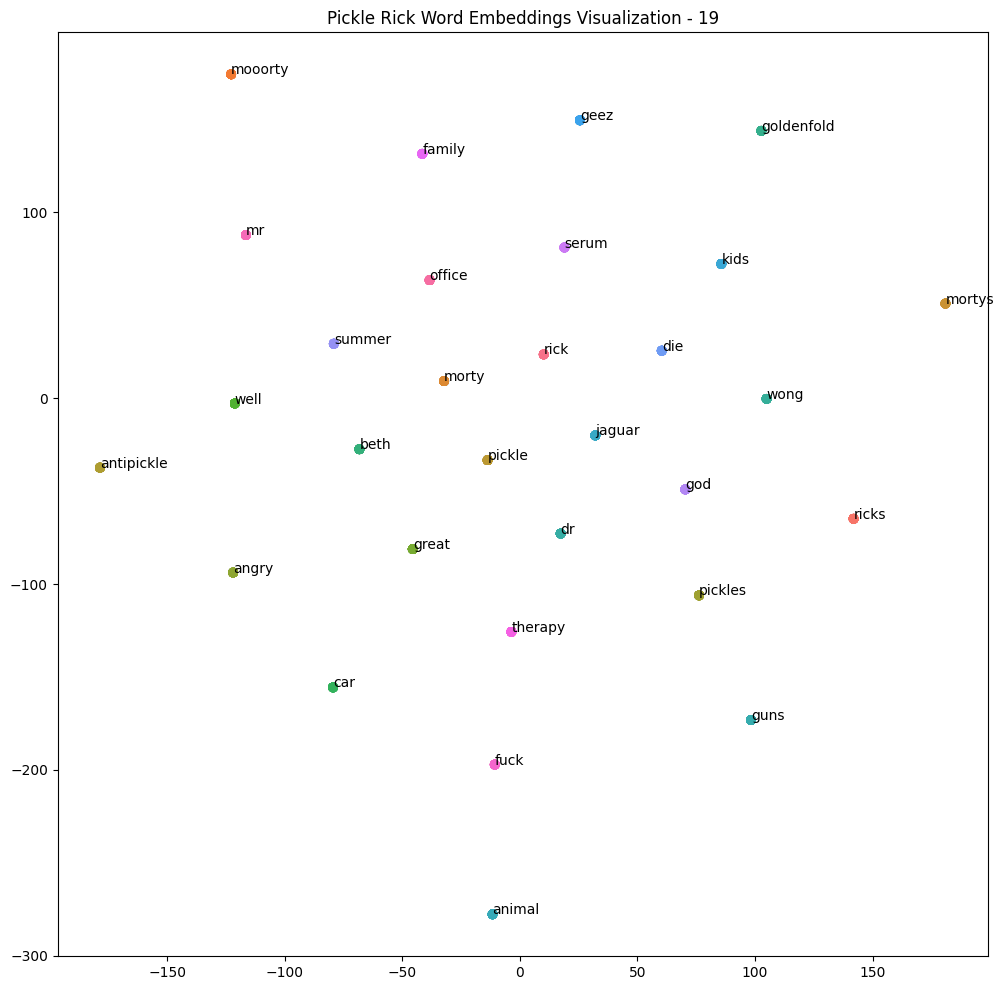

Epoch num: 21, total_batches: 1003 loss value: 6.447
Epoch num: 22, total_batches: 1003 loss value: 6.435
Epoch num: 23, total_batches: 1003 loss value: 6.446
Epoch num: 24, total_batches: 1003 loss value: 6.453
Epoch num: 25, total_batches: 1003 loss value: 6.400
Epoch num: 26, total_batches: 1003 loss value: 6.380
Epoch num: 27, total_batches: 1003 loss value: 6.342
Epoch num: 28, total_batches: 1003 loss value: 6.293
Epoch num: 29, total_batches: 1003 loss value: 6.354
Epoch num: 30, total_batches: 1003 loss value: 6.319


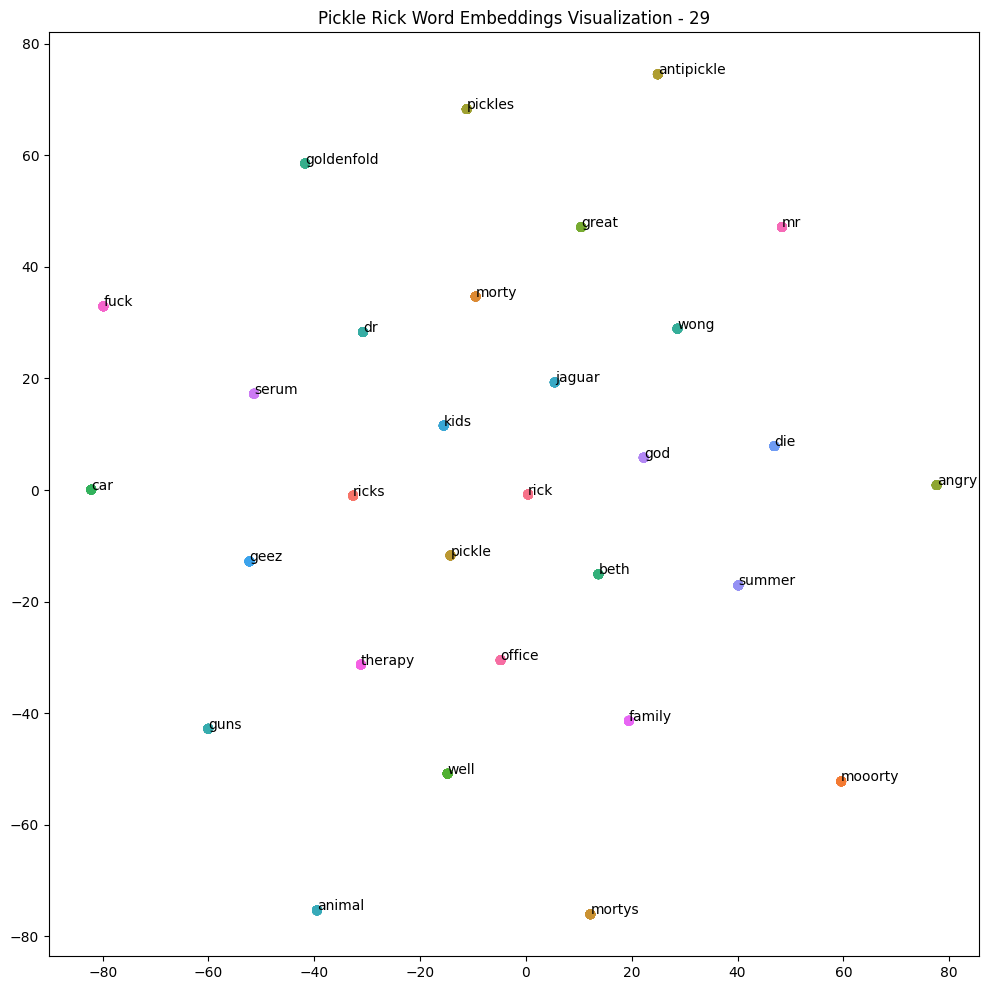

Epoch num: 31, total_batches: 1003 loss value: 6.303
Epoch num: 32, total_batches: 1003 loss value: 6.254
Epoch num: 33, total_batches: 1003 loss value: 6.232
Epoch num: 34, total_batches: 1003 loss value: 6.227
Epoch num: 35, total_batches: 1003 loss value: 6.247
Epoch num: 36, total_batches: 1003 loss value: 6.207
Epoch num: 37, total_batches: 1003 loss value: 6.198
Epoch num: 38, total_batches: 1003 loss value: 6.166
Epoch num: 39, total_batches: 1003 loss value: 6.176
Epoch num: 40, total_batches: 1003 loss value: 6.231


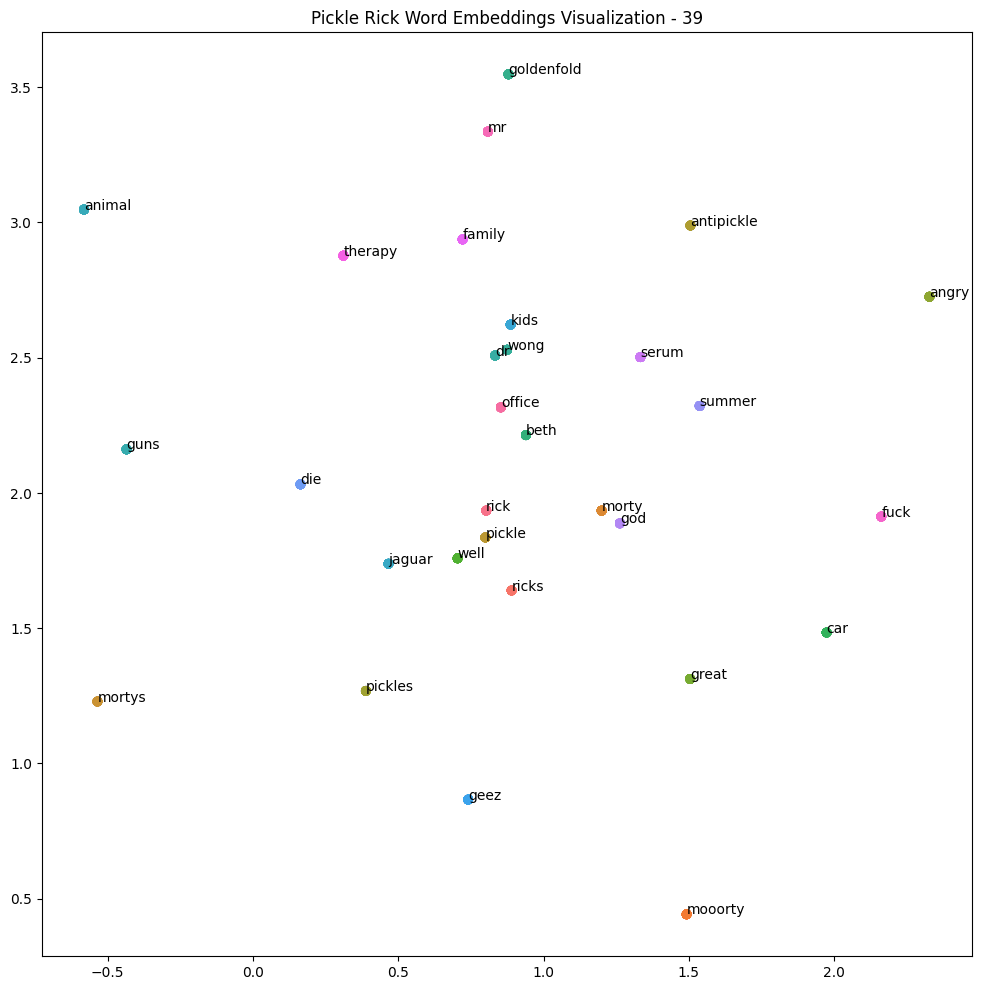

Epoch num: 41, total_batches: 1003 loss value: 6.224
Epoch num: 42, total_batches: 1003 loss value: 6.160
Epoch num: 43, total_batches: 1003 loss value: 6.193
Epoch num: 44, total_batches: 1003 loss value: 6.202
Epoch num: 45, total_batches: 1003 loss value: 6.161
Epoch num: 46, total_batches: 1003 loss value: 6.139
Epoch num: 47, total_batches: 1003 loss value: 6.171
Epoch num: 48, total_batches: 1003 loss value: 6.199
Epoch num: 49, total_batches: 1003 loss value: 6.145
Epoch num: 50, total_batches: 1003 loss value: 6.172


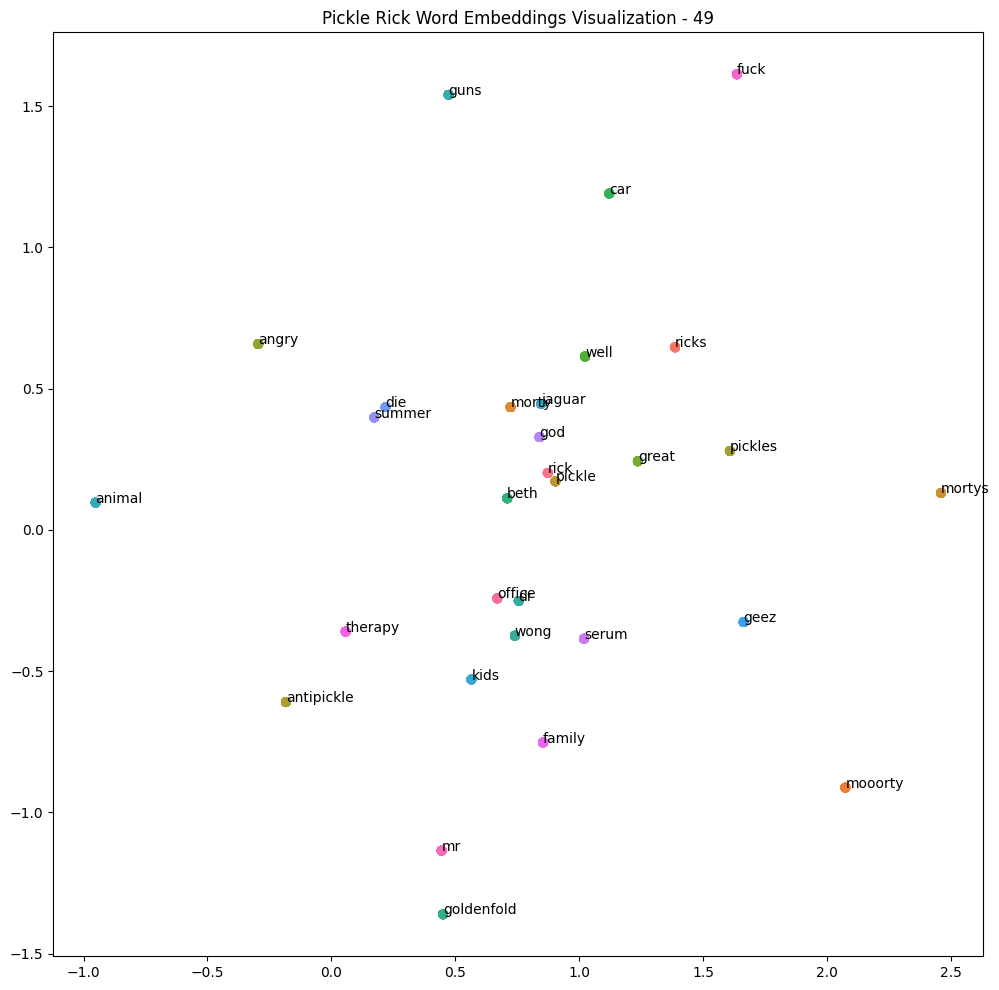

In [179]:
# Imports
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("punkt_tab")

import string
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.manifold import TSNE

import torch
import torch.nn as nn
import torch.optim as optim

# Preprocessing
text_file_path = "./pickle_rickle.txt"
def preprocess_raw_text_file(text_file_path):
    with open(text_file_path, "r") as f:
        text = f.read().replace("\n", " ")
    # Lowercase
    text = text.lower()
    # Remove punctuations like '(),[].:?'
    text = text.translate(str.maketrans("", "", string.punctuation))
    # Tokenization
    tokens = word_tokenize(text)
    # Remove stop words
    stop_words = set(stopwords.words("english"))
    # collect all words which are not stop words and not numbers, keep the order
    tokens_filtered = []
    for token in tokens:
        if token not in stop_words and not token.isnumeric():
            tokens_filtered.append(token)
    return tokens_filtered

# Mapping tokens to indices - Vectors Representing the words
def vector_representation(tokens):
    vocab = list(set(tokens))
    tok2idx = {word: idx for idx, word in enumerate(vocab)}
    idx2tok = {v: k for k, v in tok2idx.items()}
    return vocab, tok2idx, idx2word

# Generate Context-Target pairs for training
def generate_pairs(corpus_tokens, context_window_size):
    context_target_pairs = []
    for i in range(context_window_size, len(corpus_tokens)-context_window_size):
        # set target (center) word
        target = corpus_tokens[i]
        # extract sublist with context words (-3,-2,-1,target,1,2,3)
        context = corpus_tokens[i-context_window_size:i+context_window_size]
        # remove the target word from context
        context.remove(target)
        # iterate over words in window
        for ctx in context:
            context_target_pairs.append((target, ctx))
    return context_target_pairs

# define Model
class SkipGramModel(nn.Module):
    def __init__(self, voc_size, embed_size):
        super(SkipGramModel, self).__init__()
        self.embeddings = nn.Embedding(voc_size, embed_size)
        self.linear = nn.Linear(in_features=embed_size, out_features=voc_size)

    def forward(self, target):
        out = self.embeddings(target)
        out = self.linear(out)
        return out

# Visualize the embedding using tSNE
def visualize_words_embedding(model, epoch_number):
    # select a small group of words
    words_to_visualize = ['rick','ricks','mooorty', 'morty', 'mortys','pickle','antipickle','pickles','angry','great','well','car','beth','goldenfold','wong','dr','guns','animal','jaguar','kids','geez','die','summer','god','serum','family','therapy','fuck','mr','office']
    # extract the model weights
    word_vectors = model.embeddings.weight.data
    # get the word embeddings
    indices = [tok2idx[word] for word in words_to_visualize]
    word_vectors = model.embeddings.weight.data[indices]
    # fit a 2d t-SNE model to the embedding vectors
    tsne = TSNE(n_components=2, perplexity=20)
    word_vectors_2d = tsne.fit_transform(word_vectors)
    # get a specific color for each dot
    colors = sns.husl_palette(n_colors=len(words_to_visualize))
    # Create a scatter plot for projection
    plt.figure(figsize=(12, 12))
    for idx, word in enumerate(words_to_visualize):
        plt.scatter(x=word_vectors_2d[:, 0], y=word_vectors_2d[:, 1], c=colors)
        plt.annotate(text=word, xy=(word_vectors_2d[idx, 0], word_vectors_2d[idx, 1]))
    plt.title(f'Pickle Rick Word Embeddings Visualization - {epoch_number}')
    plt.show()


# Setting hyperparameters
context_window_size = 3  # context-target pairs selection

# Training hyperparameters
epochs = 50
lr = 1e-2
batch_size = 16
embed_size = 300

# Get Data
tokens_filtered = preprocess_raw_text_file(text_file_path)
vocab, tok2idx, idx2word = vector_representation(tokens_filtered)
context_target_pairs = generate_pairs(tokens_filtered, context_window_size)
# Prepare data for training
x_train, y_train = [], []
for target, context in context_target_pairs:
    x_train.append(tok2idx[target])
    y_train.append(tok2idx[context])
x_train = torch.LongTensor(x_train)  # torch.Size([16035])
y_train = torch.LongTensor(y_train)  # torch.Size([16035])
# Training
model = SkipGramModel(voc_size=len(vocab), embed_size=embed_size)
optimizer = optim.Adam(lr=lr, params=model.parameters())
loss_fn = nn.CrossEntropyLoss()
for epoch in range(epochs):
    total_loss = 0
    total_batches = 0
    for i in range(0, len(x_train), batch_size):
        X_train = x_train[i:i+batch_size]
        y_true = y_train[i:i+batch_size]
        optimizer.zero_grad()
        y_pred = model(X_train)
        loss = loss_fn(y_pred, y_true.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_batches += 1
    print(f'Epoch num: {epoch+1}, total_batches: {total_batches} loss value: {total_loss / total_batches:.3f}')
    if (epoch+1) % 10 == 0:
        visualize_words_embedding(model, epoch)


In [159]:
print(string.punctuation), print(stopwords.words("english"))

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's

(None, None)

['a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 'her',
 'here',
 'hers',
 'herself',
 "he's",
 'him',
 'himself',
 'his',
 'how',
 'i',
 "i'd",
 'if',
 "i'll",
 "i'm",
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it'd",
 "it'll",
 "it's",
 'its',
 'itself',
 "i've",
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'on

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Error loading punkt-tab: Package 'punkt-tab' not found in
[nltk_data]     index
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


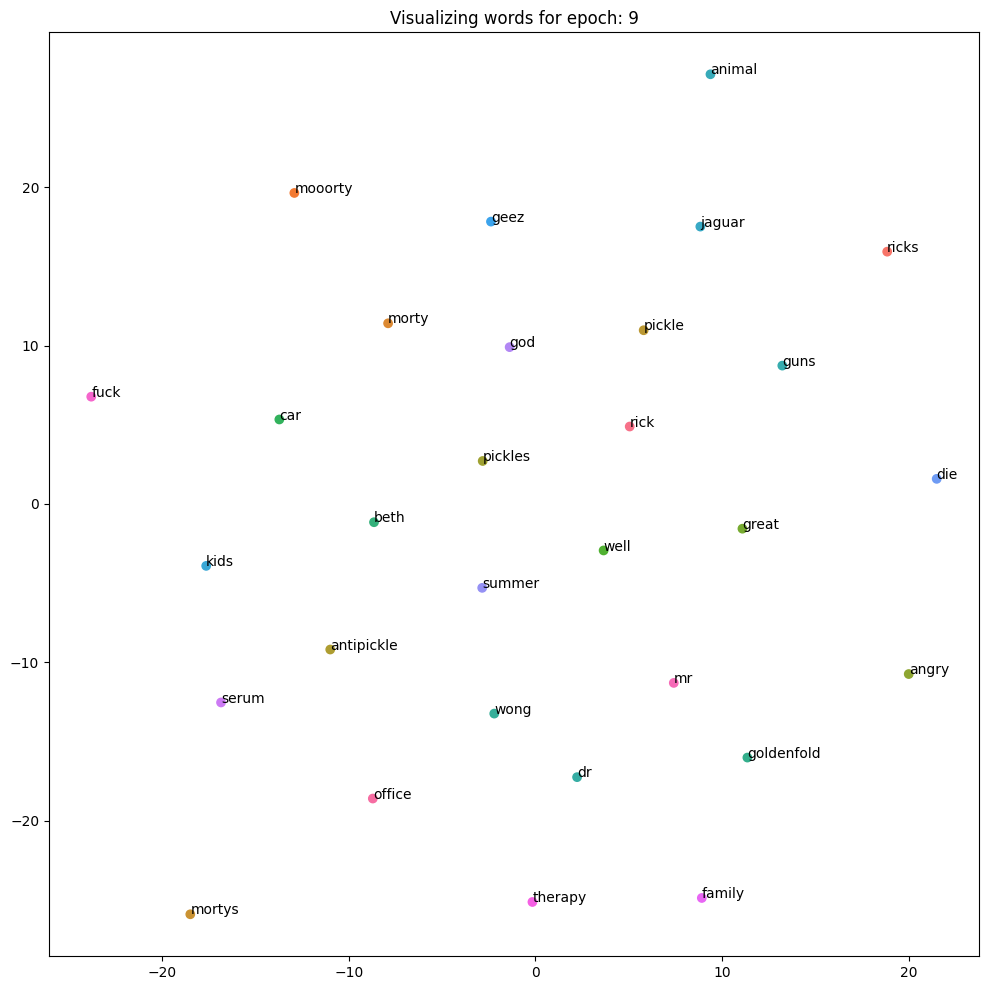

Epoch:  10 | Loss: 5.268


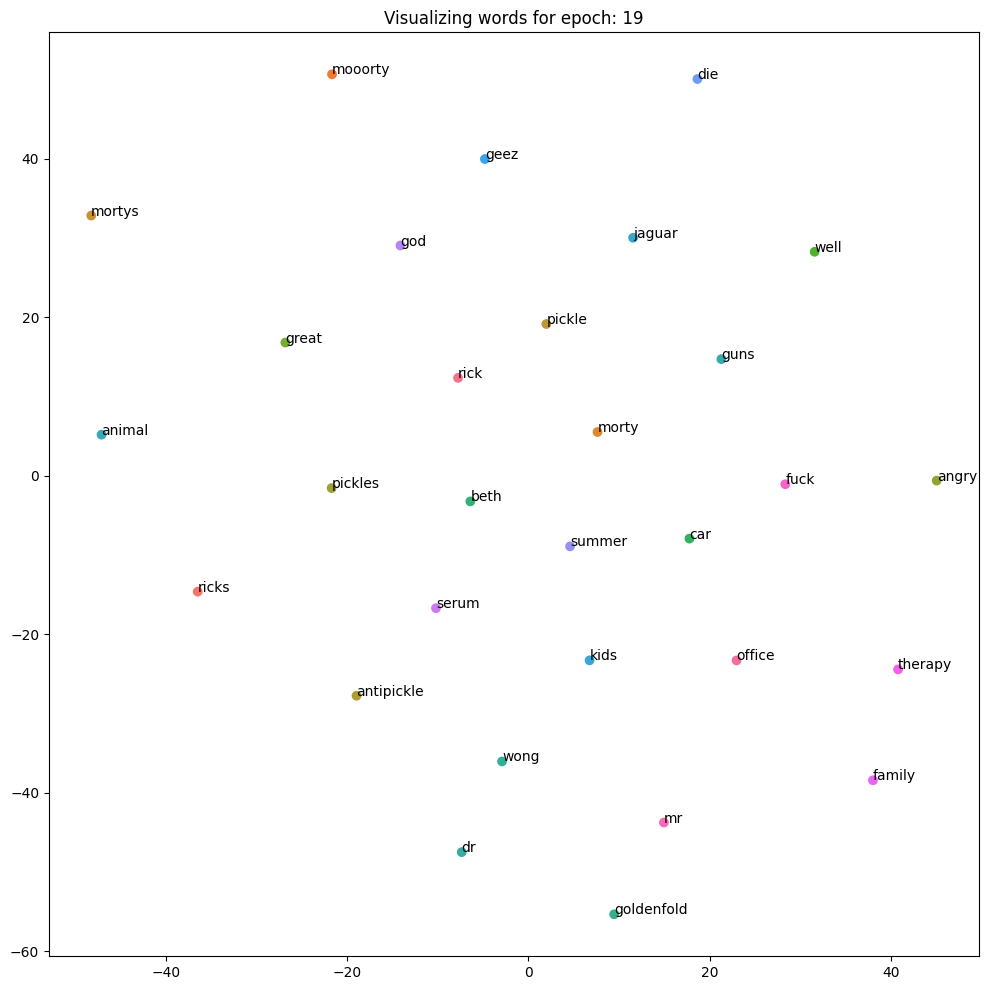

Epoch:  20 | Loss: 4.937


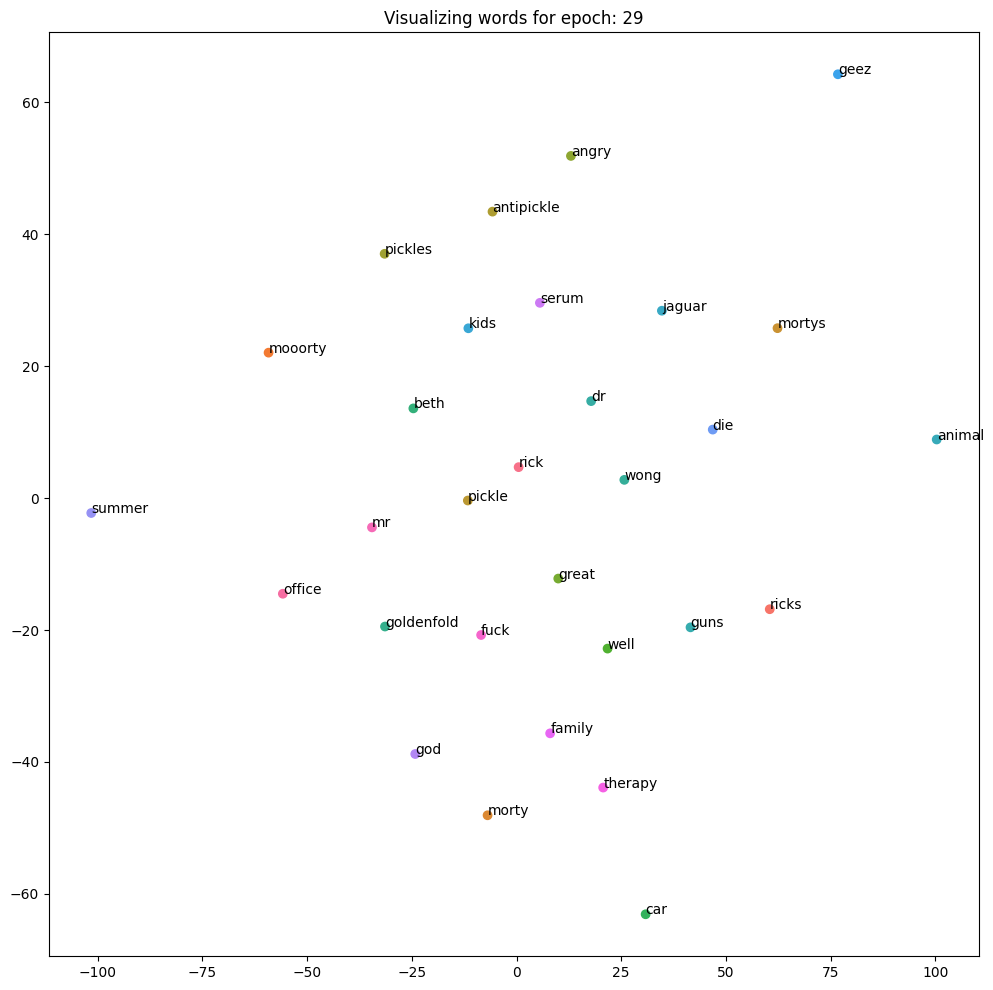

Epoch:  30 | Loss: 4.858


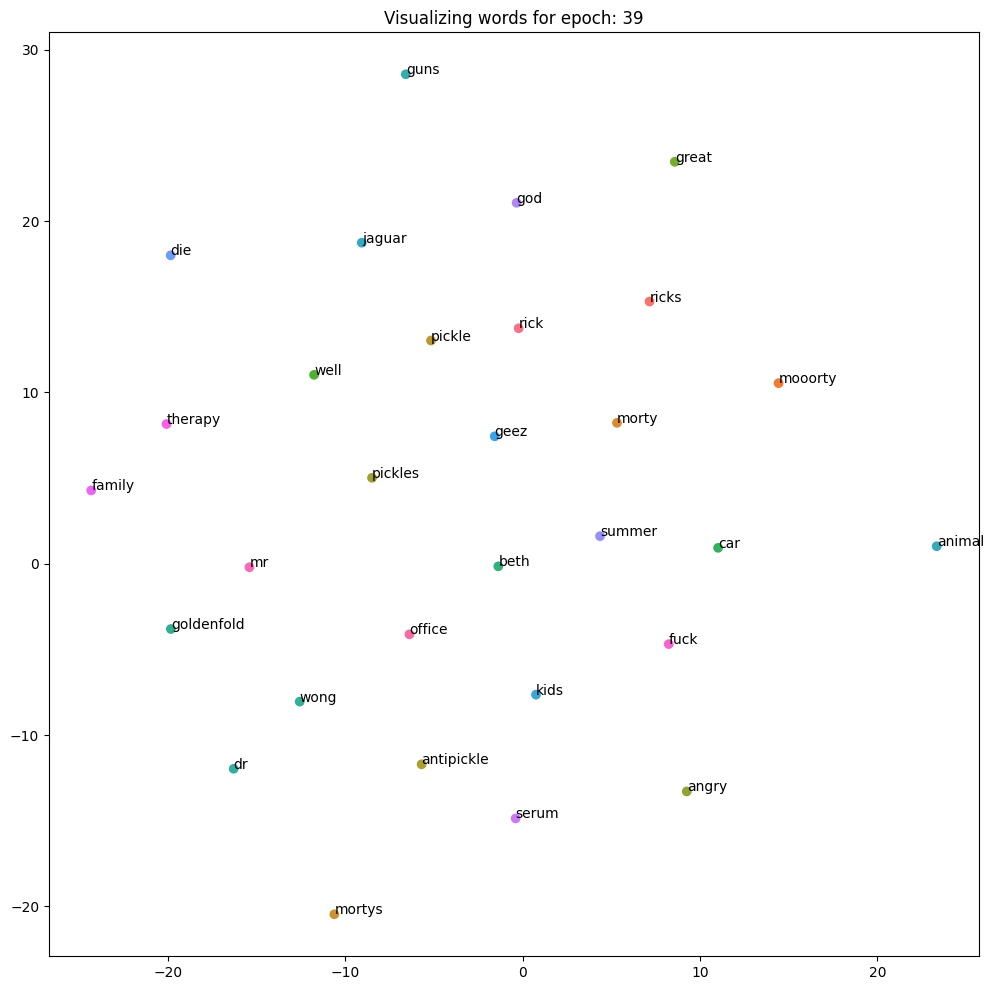

Epoch:  40 | Loss: 4.819


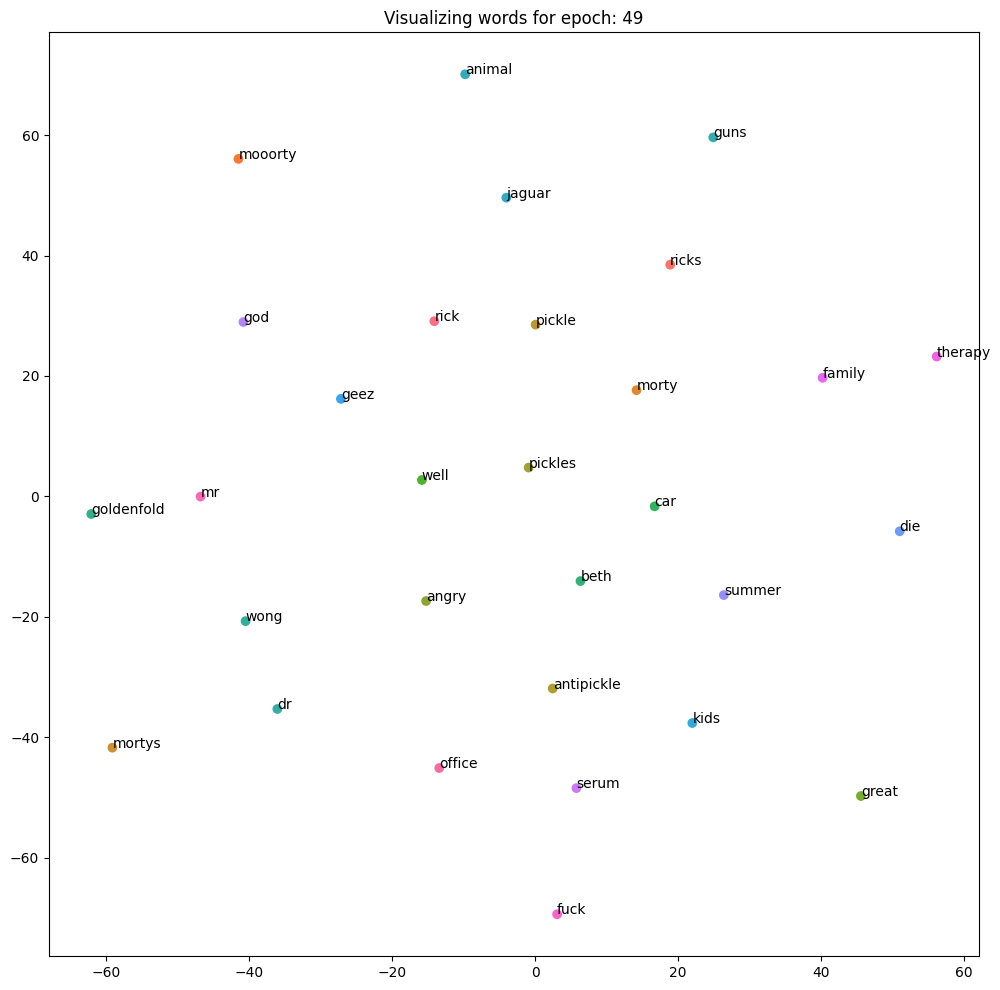

Epoch:  50 | Loss: 4.789


In [219]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
nltk.download("punkt")
nltk.download("punkt-tab")
nltk.download("stopwords")

import seaborn as sns
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

import torch
from torch import nn

def preprocess_data(text_file_path):
    with open(text_file_path, "r") as f:
        text = f.read().replace("\n", " ")
    text = text.lower()
    text = text.translate(str.maketrans("", "", string.punctuation))
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words("english"))
    filtered_tokens = []
    for token in tokens:
        if token not in stop_words and not token.isnumeric():
            filtered_tokens.append(token)
    return filtered_tokens

def vectorize_data(tokens):
    vocab = sorted(set(tokens))
    idx2word = {i: word for i, word in enumerate(vocab)}
    word2idx = {word: i for i, word in enumerate(vocab)}
    return vocab, idx2word, word2idx

def prepare_pairs(tokens, context_window_size):
    target_context_pairs = []
    tokens_length = len(tokens)
    for i in range(context_window_size, tokens_length-context_window_size):
        target = tokens[i]
        context = tokens[i-context_window_size:i+context_window_size]
        context.remove(target)
        for ctx in context:
            target_context_pairs.append((target, ctx))
    return target_context_pairs

class SkipGramModel(nn.Module):
    def __init__(self, voc_size, embed_size):
        super(SkipGramModel, self).__init__()
        self.embeddings = nn.Embedding(voc_size, embed_size)
        self.linear = nn.Linear(embed_size, voc_size)

    def forward(self, x_train_target):
        out = self.embeddings(x_train_target)
        out = self.linear(out)
        return out

def visualize_embeddings(model, epoch):
    words = ['rick','ricks','mooorty', 'morty', 'mortys','pickle','antipickle','pickles','angry','great','well','car','beth','goldenfold','wong','dr','guns','animal','jaguar','kids','geez','die','summer','god','serum','family','therapy','fuck','mr','office']
    indices = list(map(lambda w: word2idx[w], words))
    word_vectors = model.embeddings.weight.data[indices]
    tsne = TSNE(n_components=2, perplexity=20)
    word_vectors_2d = tsne.fit_transform(word_vectors)
    colors = sns.husl_palette(n_colors=len(words))
    plt.figure(figsize=(12, 12))
    plt.scatter(word_vectors_2d[:, 0], word_vectors_2d[:, 1], c=colors)
    for idx, word in enumerate(words):
        plt.annotate(word, xy=(word_vectors_2d[idx, 0], word_vectors_2d[idx, 1]))
    plt.title(f"Visualizing words for epoch: {epoch}")
    plt.show()

# hyperparemeters
context_window_size = 3
epochs = 50
lr = 1e-2
bs = 16
embed_size = 300

tokens = preprocess_data(text_file_path="./pickle_rickle.txt")
vocab, idx2word, word2idx = vectorize_data(tokens)
target_context_pairs = prepare_pairs(tokens, context_window_size)
x, y = [], []
for target, ctx in target_context_pairs:
    x.append(word2idx[target])
    y.append(word2idx[ctx])
X = torch.LongTensor(x)
Y = torch.LongTensor(y)
voc_size = len(vocab)

model = SkipGramModel(voc_size=voc_size, embed_size=embed_size)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lr=lr, params=model.parameters())
for epoch in range(epochs):
    perm = torch.randperm(len(X))
    X = X[perm]
    Y = Y[perm]
    total_loss = 0.0
    batch_size = 0
    for i in range(0, len(X), bs):
        x_train = X[i:i+bs]
        y_true = Y[i:i+bs]
        y_pred = model(x_train)
        optimizer.zero_grad()
        loss = loss_fn(y_pred, y_true.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        batch_size += 1
    if (epoch + 1) % 10 == 0:
        visualize_embeddings(model, epoch)
        print(f"Epoch: {epoch+1:3.0f} | Loss: {total_loss / batch_size:5.3f}")